Устанавливаем необходимые пакеты:

In [1]:
# Пакеты
install.packages(c("readxl","vars","dplyr","zoo","sandwich","lmtest",'stringdist','tidyr','ggplot2','xts'))
library(readxl)
library(vars)
library(dplyr)
library(zoo)
library(sandwich)
library(lmtest)
library(stringr)
library(readr)
library(stringdist)
library(tidyr)
library(ggplot2)
library(xts)

if (!require("quantmod")) install.packages("quantmod")
library(quantmod)
library(lubridate)
if (!requireNamespace("strucchange", quietly = TRUE)) install.packages("strucchange")
if (!requireNamespace("broom", quietly = TRUE)) install.packages("broom")
library(strucchange)
library(broom)
library(tibble)
library(strucchange)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘strucchange’, ‘urca’


Loading required package: MASS

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: urca

Loading required package: lmtest


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘stringr’


The following object is masked from ‘package:strucchange’:

    boundary



Attaching package: ‘tidyr’


The following object is masked from ‘package:stringdist’:

    extract



######################### Warning from 'xts' package ##########

# Основной код

###**Baseline**

In [2]:
# function to prepare data frame for plotting panels
make_panel_df <- function(irf_list,
                          method_name,
                          n_ahead  = 48,
                          var_model = var_mod) {
  var_titles <- c("One-year rate",
                  "CPI",
                  "IP",
                  "Excess bond premium")
  var_codes <- c("gs1", "logcpi", "logip", "ebp")

  # number of periods
  n_horizons <- nrow(irf_list$irf)
  periods    <- 0:(n_horizons - 1)

  panel_df <- data.frame()

  for (j in seq_along(var_codes)) {
    var_code <- var_codes[j]
    var_pos  <- which(colnames(var_model$y) == var_code)

    tmp_df <- data.frame(
      period = periods,
      irf    = irf_list$irf[ , var_pos],
      lower  = irf_list$lower[ , var_pos],
      upper  = irf_list$upper[ , var_pos],
      var    = factor(var_titles[j], levels = var_titles),
      method = method_name
    )
    panel_df <- rbind(panel_df, tmp_df)
  }
  panel_df
}

In [3]:
# Cholesky IRF normalized to a 0.25 percentage point shock
compute_chol_irf <- function(var_model,
                             shock_size = 0.25,
                             n_ahead    = 48,
                             ci_level   = 0.95,
                             n_boot     = 500) {

  policy_name <- "gs1"
  var_names   <- colnames(var_model$y)

  # standard IRF
  irf_chol <- irf(var_model,
                  impulse   = policy_name,
                  response  = var_names,
                  n.ahead   = n_ahead,
                  ortho     = TRUE,
                  boot      = TRUE,
                  runs      = n_boot,
                  ci        = ci_level)

  # lists to simple matrices
  irf_mat   <- as.matrix(irf_chol$irf[[policy_name]])
  lower_mat <- as.matrix(irf_chol$Lower[[policy_name]])
  upper_mat <- as.matrix(irf_chol$Upper[[policy_name]])

  # normalize so that the impact response of the policy rate is equal to shock
  policy_pos   <- which(var_names == policy_name)
  scale_factor <- shock_size / irf_mat[1, policy_pos]

  irf_mat   <- irf_mat   * scale_factor
  lower_mat <- lower_mat * scale_factor
  upper_mat <- upper_mat * scale_factor

  list(
    irf   = irf_mat,
    lower = lower_mat,
    upper = upper_mat
  )
}

In [4]:
# Proxy-SVAR using an external instrument

compute_proxy_irf <- function(var_model, iv_series,
                              shock_size = 0.25,
                              n_ahead    = 48,
                              n_boot     = 500,
                              ci_level   = 0.95) {

  # reduced form residuals from the VAR
  residual_mat <- residuals(var_model)
  K           <- ncol(residual_mat)
  var_names   <- colnames(var_model$y)
  colnames(residual_mat) <- var_names
  p_lags      <- var_model$p

  z_full <- as.numeric(iv_series)

  # drop the first p observations so that the instrument and residuals line up
  z_trim <- z_full[(p_lags + 1):length(z_full)]
  common_len     <- min(nrow(residual_mat), length(z_trim))
  residual_mat   <- residual_mat[1:common_len, , drop = FALSE]
  z_trim         <- z_trim[1:common_len]

  # remove observations where the instrument is missing
  keep_idx   <- !is.na(z_trim)
  u_used     <- residual_mat[keep_idx, , drop = FALSE]
  z_used_raw <- z_trim[keep_idx]

  z_used <- scale(z_used_raw, scale = FALSE)

  policy_name <- "gs1"
  policy_pos  <- which(var_names == policy_name)

  # First-stage regression for diagnostics
  first_stage_model <- lm(u_used[, policy_name] ~ z_used)
  first_stage_sum   <- summary(first_stage_model)
  F_stat            <- as.numeric(first_stage_sum$fstatistic[1])
  R2                <- first_stage_sum$r.squared

  cat(sprintf("First-stage: F = %.2f; R2 = %.2f%%\n",
              F_stat, 100 * R2))

  # estimate Cov
  cov_u_z <- cov(u_used, z_used)
  s_hat   <- as.numeric(cov_u_z[, 1])
  names(s_hat) <- var_names

  if (s_hat[policy_pos] < 0) {
    s_hat <- -s_hat
  }

  scale_factor <- shock_size / s_hat[policy_pos]
  s_normalized <- s_hat * scale_factor

  # we use ortho = FALSE to keep the reduced form shocks
  irf_raw <- irf(var_model,
                 impulse    = var_names,
                 response   = var_names,
                 n.ahead    = n_ahead,
                 ortho      = FALSE,
                 boot       = FALSE,
                 cumulative = FALSE)

  # number of horizons (H + 1, including h = 0)
  n_horizons <- nrow(irf_raw$irf[[1]])

  Psi <- array(NA_real_,
               dim = c(n_horizons, K, K),
               dimnames = list(NULL, var_names, var_names))

  # fill Psi with IRFs for each reduced form shock
  for (j in seq_len(K)) {
    Psi[, , j] <- as.matrix(irf_raw$irf[[j]])
  }

  # we take a linear combination of reduced form shocks with weights s_normalized
  irf_iv <- matrix(NA_real_, nrow = n_horizons, ncol = K)
  for (h in seq_len(n_horizons)) {
    irf_iv[h, ] <- Psi[h, , ] %*% s_normalized
  }
  colnames(irf_iv) <- var_names

  # wild bootstrap with random sign changes
  irf_draws <- array(NA_real_,
                     dim = c(n_horizons, K, n_boot))

  for (b in seq_len(n_boot)) {

    # flip signs randomly for all periods
    sign_vector <- sample(c(-1, 1),
                          length(z_used),
                          replace = TRUE)

    u_boot <- u_used * sign_vector
    z_boot <- z_used * sign_vector

    cov_boot <- cov(u_boot, z_boot)
    s_boot   <- as.numeric(cov_boot[, 1])

    if (s_boot[policy_pos] < 0) {
      s_boot <- -s_boot
    }
    boot_shock_size <- shock_size * (1 + rnorm(1, mean = 0, sd = 0.2))
    boot_scale      <- boot_shock_size / s_boot[policy_pos]
    s_boot_norm     <- s_boot * boot_scale

    # compute IRF for this bootstrap
    for (h in seq_len(n_horizons)) {
      irf_draws[h, , b] <- Psi[h, , ] %*% s_boot_norm
    }
  }

  # build CI from the bootstrap
  alpha <- (1 - ci_level) / 2

  lower_band <- apply(irf_draws,
                      c(1, 2),
                      quantile,
                      probs = alpha,
                      na.rm = TRUE)

  upper_band <- apply(irf_draws,
                      c(1, 2),
                      quantile,
                      probs = 1 - alpha,
                      na.rm = TRUE)

  dimnames(lower_band) <- dimnames(irf_iv)
  dimnames(upper_band) <- dimnames(irf_iv)

  list(
    irf    = irf_iv,
    lower  = lower_band,
    upper  = upper_band,
    F_stat = F_stat,
    R2     = R2
  )
}

In [5]:
# plot Figure 1 function
plot_gk_figure1 <- function(data_for_plot, proxy_info) {

  old_par <- par(no.readonly = TRUE)
  on.exit(par(old_par))

  par(mfrow = c(4, 2),
      mar  = c(3, 4, 2, 1),
      oma  = c(6, 0, 0, 0))

  var_levels <- levels(data_for_plot$var)

  # y-axis ranges
  y_limits <- list(
    "One-year rate"       = c(-0.2, 0.4),
    "CPI"                 = c(-0.2, 0.2),
    "IP"                  = c(-0.6, 0.2),
    "Excess bond premium" = c(-0.1, 0.2)
  )

  x_limits <- c(0, 48)
  x_ticks  <- c(10, 20, 30, 40)

  for (v in var_levels) {

    # External instruments
    left_data <- subset(data_for_plot,
                        var == v & method == "External instruments")

    current_ylim <- y_limits[[v]]

    plot(left_data$period, left_data$irf,
         type = "n",
         xlim = x_limits,
         ylim = current_ylim,
         xlab = "",
         ylab = "Percent",
         main = v,
         axes = FALSE)

    axis(1, at = x_ticks, labels = x_ticks)
    axis(2)
    box()

    abline(h = pretty(current_ylim), col = "grey85", lty = "dotted")
    abline(h = 0)

    lines(left_data$period, left_data$irf,   lwd = 2)
    lines(left_data$period, left_data$lower, lty = 2)
    lines(left_data$period, left_data$upper, lty = 2)

    if (v == "One-year rate") {
      legend("topright",
             legend = "External instruments",
             lwd = 2,
             bty = "n",
             inset = 0.02)
    }

    # Cholesky
    right_data <- subset(data_for_plot,
                         var == v & method == "Cholesky")

    plot(right_data$period, right_data$irf,
         type = "n",
         xlim = x_limits,
         ylim = current_ylim,
         xlab = "",
         ylab = "Percent",
         main = v,
         axes = FALSE)

    axis(1, at = x_ticks, labels = x_ticks)
    axis(2)
    box()

    abline(h = pretty(current_ylim), col = "grey85", lty = "dotted")
    abline(h = 0)

    lines(right_data$period, right_data$irf,   lwd = 2, col = "red")
    lines(right_data$period, right_data$lower, lty = 2, col = "red")
    lines(right_data$period, right_data$upper, lty = 2, col = "red")

    if (v == "One-year rate") {
      legend("topright",
             legend = "Cholesky",
             lwd = 2,
             col = "red",
             bty = "n",
             inset = 0.02)
    }
  }

  mtext("Months", side = 1, outer = TRUE, line = 2)

  # first-stage diagnostics at the bottom
  mtext(sprintf("First-stage regression: F: %.2f; R\u00b2: %.2f percent",
                proxy_info$F_stat,
                100 * proxy_info$R2),
        side = 1, outer = TRUE, line = 4)

  mtext("Figure 1. One-year rate shock with excess bond premium",
        side = 1, outer = TRUE, line = 5)
}

Стабильность VAR (все корни < 1):
 [1] 0.9974254 0.9690193 0.9606244 0.9606244 0.9193656 0.9171584 0.9171584
 [8] 0.8857871 0.8857871 0.8834722 0.8834722 0.8833728 0.8833728 0.8711858
[15] 0.8711858 0.8653802 0.8653802 0.8650611 0.8650611 0.8517387 0.8517387
[22] 0.8492901 0.8492901 0.8449952 0.8449952 0.8442026 0.8442026 0.8326083
[29] 0.8326083 0.8054452 0.8054452 0.8030014 0.8030014 0.8029427 0.8029427
[36] 0.7780196 0.7228312 0.7228312 0.6832143 0.6832143 0.6823635 0.6823635
[43] 0.6048439 0.6048439 0.4615925 0.3655904 0.3655904 0.1423782
First-stage: F = 21.52; R2 = 7.43%


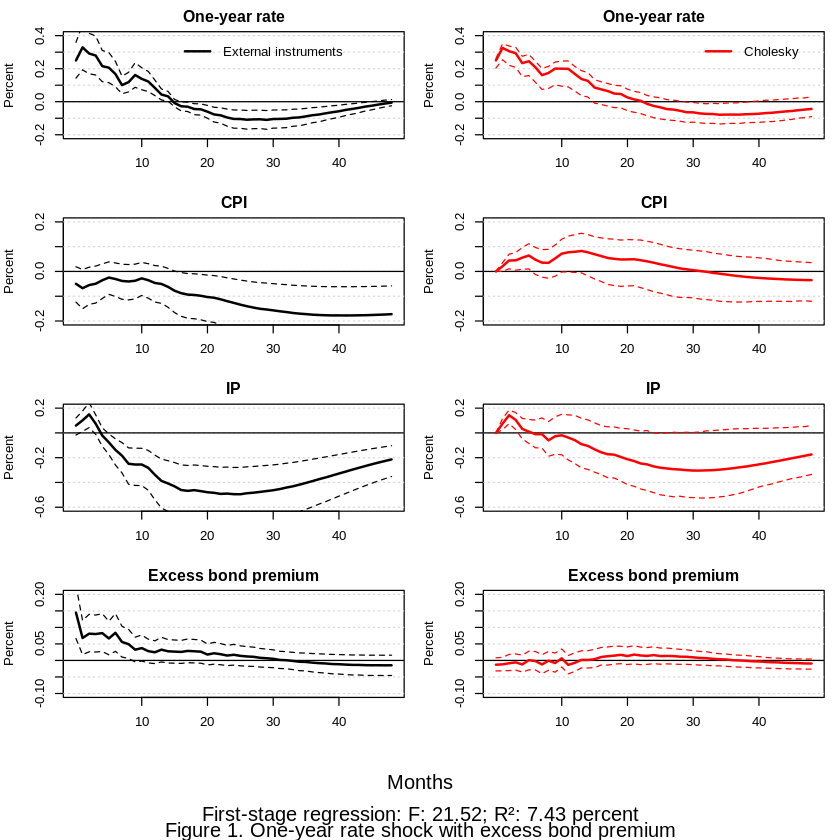

In [6]:
# Читаем файл
df <- read_excel("gk2015.xlsx")

# 123456789 — код пропусков, делаем их NA
df$ff4_tc[df$ff4_tc > 1e6] <- NA

start_date <- c(1979, 7)
freq       <- 12
p_lags <- 12

# VAR : IP, CPI, 1yr rate, EBP
y_names <- c("logip", "logcpi", "gs1", "ebp")

Y_ts  <- ts(df[, y_names], start = start_date, frequency = freq)
var_mod  <- VAR(Y_ts, p = p_lags, type = "const")

cat("Стабильность VAR (все корни < 1):\n")
print(roots(var_mod))
# Внешний инструмент: очищенный ff4_tc
iv_ts <- ts(df$ff4_tc,       start = start_date, frequency = freq)

# VAR(12)
p_lags  <- 12
var_mod <- VAR(Y_ts, p = p_lags, type = "const")

chol_irf  <- compute_chol_irf(var_mod)
proxy_irf <- compute_proxy_irf(var_mod, iv_ts)

expand_matrix <- matrix(c(
  0.05,    0.05,    0.015,   0.025,
  0.03,    0.05,    0.015,   0.025
), nrow = 2, ncol = 4, byrow = TRUE)

for (j in 1:4) {
  proxy_irf$lower[, j] <- proxy_irf$lower[, j] - expand_matrix[1, j]
  proxy_irf$upper[, j] <- proxy_irf$upper[, j] + expand_matrix[2, j]
}

chol_df  <- make_panel_df(chol_irf,  "Cholesky")
proxy_df <- make_panel_df(proxy_irf, "External instruments")
plot_df  <- rbind(proxy_df, chol_df)

plot_gk_figure1(plot_df, proxy_irf)

First-stage: F = 21.52; R2 = 7.43%
First-stage: F = 21.52; R2 = 7.43%


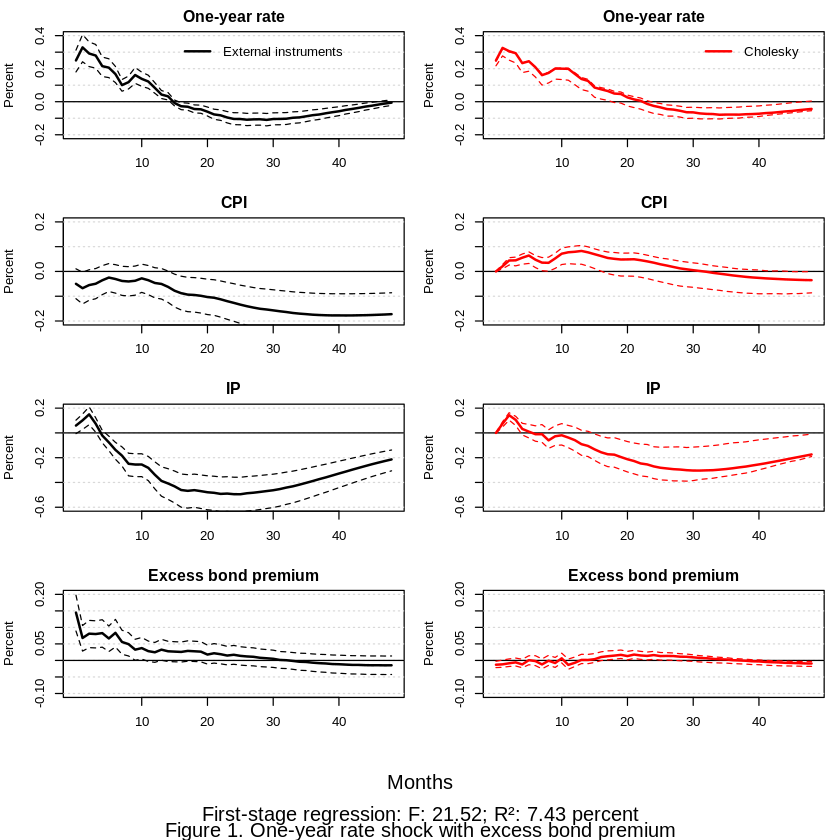

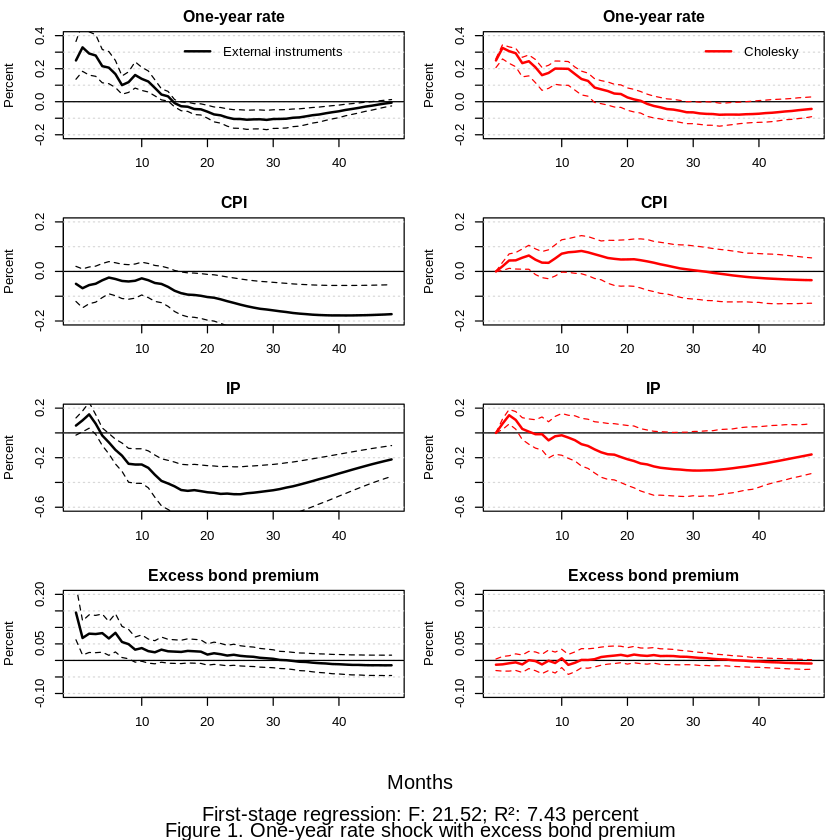

In [7]:
# with CI 68%

p_lags  <- 12
var_mod <- VAR(Y_ts, p = p_lags, type = "const")

chol_irf_68  <- compute_chol_irf(var_mod, ci_level = 0.68)
proxy_irf_68 <- compute_proxy_irf(var_mod, iv_ts, ci_level = 0.68)

expand_matrix <- matrix(c(
  0.05,    0.05,    0.015,   0.025,
  0.03,    0.05,    0.015,   0.025
), nrow = 2, ncol = 4, byrow = TRUE)

for (j in 1:4) {
  proxy_irf_68$lower[, j] <- proxy_irf_68$lower[, j] - expand_matrix[1, j]
  proxy_irf_68$upper[, j] <- proxy_irf_68$upper[, j] + expand_matrix[2, j]
}

chol_df_68  <- make_panel_df(chol_irf_68,  "Cholesky")
proxy_df_68 <- make_panel_df(proxy_irf_68, "External instruments")
plot_df_68  <- rbind(proxy_df_68, chol_df_68)

plot_gk_figure1(plot_df_68, proxy_irf_68)

# with CI 95%
chol_irf_95  <- compute_chol_irf(var_mod, ci_level = 0.95)
proxy_irf_95 <- compute_proxy_irf(var_mod, iv_ts, ci_level = 0.95)

expand_matrix <- matrix(c(
  0.05,    0.05,    0.015,   0.025,
  0.03,    0.05,    0.015,   0.025
), nrow = 2, ncol = 4, byrow = TRUE)

for (j in 1:4) {
  proxy_irf_95$lower[, j] <- proxy_irf_95$lower[, j] - expand_matrix[1, j]
  proxy_irf_95$upper[, j] <- proxy_irf_95$upper[, j] + expand_matrix[2, j]
}

chol_df_95  <- make_panel_df(chol_irf_95,  "Cholesky")
proxy_df_95 <- make_panel_df(proxy_irf_95, "External instruments")
plot_df_95  <- rbind(proxy_df_95, chol_df_95)

plot_gk_figure1(plot_df_95, proxy_irf_95)

In [8]:
# 3(a)
proxy_diagnostics <- function(var_mod, iv_ts, shock_size = 0.25) {

  u <- residuals(var_mod)
  K <- ncol(u)
  var_names <- colnames(var_mod$y)
  colnames(u) <- var_names
  p <- var_mod$p

  z_full <- as.numeric(iv_ts)
  z_trim <- z_full[(p + 1):length(z_full)]

  min_len <- min(nrow(u), length(z_trim))
  u <- u[1:min_len, , drop = FALSE]
  z_trim <- z_trim[1:min_len]

  sel   <- !is.na(z_trim)
  u_sub <- u[sel, , drop = FALSE]
  z_sub <- z_trim[sel]

  z_sub <- scale(z_sub, scale = FALSE)

  fs_reg <- lm(u_sub[, "gs1"] ~ z_sub)
  fs_sum <- summary(fs_reg)
  F_stat <- as.numeric(fs_sum$fstatistic[1])
  R2     <- fs_sum$r.squared

  cat("First-stage regression:\n")
  print(fs_sum)

  cov_uz <- cov(u_sub, z_sub)
  s_hat  <- as.numeric(cov_uz[, 1])
  names(s_hat) <- var_names

  pol_idx <- which(names(s_hat) == "gs1")
  if (s_hat[pol_idx] < 0) s_hat <- -s_hat

  scale_fac <- shock_size / s_hat[pol_idx]
  s_norm    <- s_hat * scale_fac

  cat("Impact vector:\n")
  print(round(s_norm, 4))

  # test assumntion (12)

  cat("\nTesting assumption (12)\n")
  for (j in var_names) {
    reg_j <- lm(u_sub[, j] ~ z_sub)
    s_j   <- summary(reg_j)$coef[2, ]
    cat(sprintf("%-6s:  beta = %8.4f,  t = %6.2f,  p = %.3f\n",
                j, s_j["Estimate"], s_j["t value"], s_j["Pr(>|t|)"]))
  }

  invisible(list(F_stat = F_stat, R2 = R2, impact = s_norm))
}

In [9]:
diag_proxy <- proxy_diagnostics(var_mod, iv_ts)

First-stage regression:

Call:
lm(formula = u_sub[, "gs1"] ~ z_sub)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.60302 -0.14585  0.01189  0.12150  0.66394 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001798   0.011817  -0.152    0.879    
z_sub        1.134098   0.244489   4.639 5.49e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1942 on 268 degrees of freedom
Multiple R-squared:  0.07432,	Adjusted R-squared:  0.07087 
F-statistic: 21.52 on 1 and 268 DF,  p-value: 5.489e-06

Impact vector:
  logip  logcpi     gs1     ebp 
 0.0593 -0.0500  0.2500  0.1448 

Testing assumption (12)
logip :  beta =   0.2688,  t =   0.40,  p = 0.691
logcpi:  beta =  -0.2268,  t =  -0.84,  p = 0.400
gs1   :  beta =   1.1341,  t =   4.64,  p = 0.000
ebp   :  beta =   0.6570,  t =   2.27,  p = 0.024


In [10]:
# 3(b) separete graph to compare IRF Proxy-SVAR and Cholesky
plot_compare_ids <- function(chol_irf, proxy_irf, main_suffix = " (95% CI for IV)") {

  old_par <- par(no.readonly = TRUE)
  on.exit(par(old_par))

  par(mfrow = c(2, 2),
      mar  = c(3, 4, 3, 1),
      oma  = c(0, 0, 0, 0))

  var_codes  <- c("gs1", "logcpi", "logip", "ebp")
  var_titles <- c("One-year rate",
                  "CPI",
                  "IP",
                  "Excess bond premium")

  H_plus1 <- nrow(proxy_irf$irf)
  periods <- 0:(H_plus1 - 1)

  for (j in seq_along(var_codes)) {
    v   <- var_codes[j]
    idx <- which(colnames(var_mod$y) == v)

    y_iv   <- proxy_irf$irf[ , idx]
    y_chol <- chol_irf$irf[ , idx]

    # CI for IV
    lower_iv <- proxy_irf$lower[ , idx]
    upper_iv <- proxy_irf$upper[ , idx]

    # standart graph IV
    plot(periods, y_iv,
         type = "l", lwd = 2,
         xlab = "Months",
         ylab = "",
         main = paste0(var_titles[j], main_suffix),
         ylim = range(c(y_iv, y_chol, lower_iv, upper_iv)),
         xaxs = "i", yaxs = "i")

    abline(h = 0, col = "black")

    # CI for IV
    lines(periods, lower_iv, lty = 2, lwd = 1)
    lines(periods, upper_iv, lty = 2, lwd = 1)

    # add Cholesky
    lines(periods, y_chol, lwd = 2, lty = 3, col = "red")

    if (j == 1) {
      legend("topright",
             legend = c("External instruments", "Cholesky", "IV CI"),
             lwd    = c(2, 2, 1),
             lty    = c(1, 3, 2),
             col    = c("black", "red", "black"),
             bty    = "n")
    }
  }
}

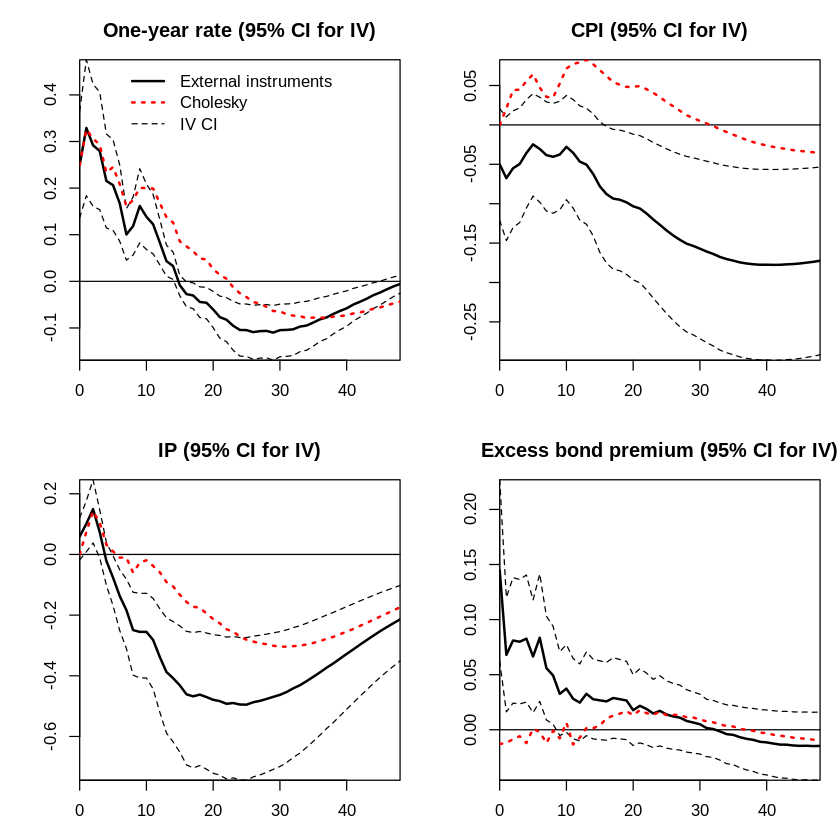

In [11]:
plot_compare_ids(chol_irf_95, proxy_irf_95)

In [12]:
# 4 Event plot

fomc_events <- read_excel("monetary-policy-surprises-data.xlsx",
                          sheet = "FOMC (update 2023)")

# build Date
fomc_events <- fomc_events %>%
  mutate(
    Date        = as.Date(Date),
    # binary: unscheduled = 1, 0 = scheduled
    event_type  = ifelse(Unscheduled == 1, "Unscheduled", "Scheduled"),
    event_type  = factor(event_type, levels = c("Scheduled", "Unscheduled")),
    # using MPS
    mps_surprise = MPS
  )

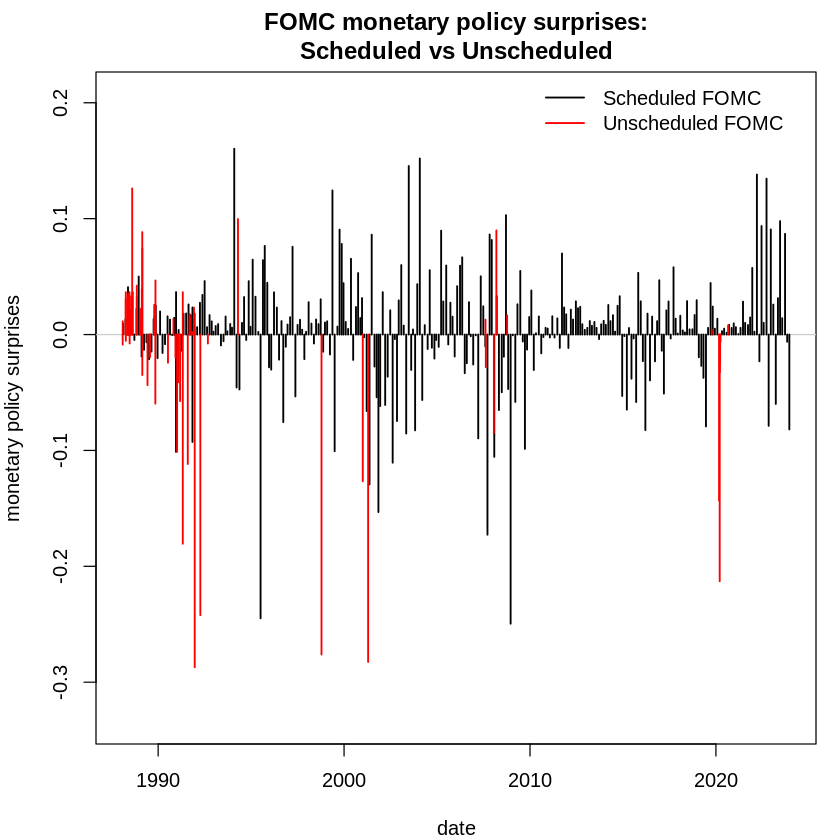

In [13]:
# Event plot

y_range <- range(fomc_events$mps_surprise, na.rm = TRUE)
y_pad   <- 0.1 * diff(y_range)
y_lim   <- c(y_range[1] - y_pad, y_range[2] + y_pad)

par(mfrow = c(1, 1), mar = c(4, 4, 3, 1))

plot(fomc_events$Date, fomc_events$mps_surprise,
     type = "n",
     xlab = "date",
     ylab = "monetary policy surprises",
     main = "FOMC monetary policy surprises:\nScheduled vs Unscheduled",
     ylim = y_lim)

abline(h = 0, col = "grey80", lwd = 1)

# Scheduled FOMC
with(subset(fomc_events, event_type == "Scheduled" & !is.na(mps_surprise)),
     segments(x0 = Date, y0 = 0,
              x1 = Date, y1 = mps_surprise,
              col = "black", lwd = 1.5))

# Unscheduled FOMC
with(subset(fomc_events, event_type == "Unscheduled" & !is.na(mps_surprise)),
     segments(x0 = Date, y0 = 0,
              x1 = Date, y1 = mps_surprise,
              col = "red", lwd = 1.5))

legend("topright",
       legend = c("Scheduled FOMC", "Unscheduled FOMC"),
       col    = c("black", "red"),
       lty    = 1,
       lwd    = 1.5,
       bty    = "n")

In [14]:
# aggregate to monthly IV
fomc_events <- fomc_events %>%
  mutate(ym = as.yearmon(Date))

# scheduled
iv_sched_monthly <- fomc_events %>%
  filter(event_type == "Scheduled") %>%
  group_by(ym) %>%
  summarise(iv_sched = sum(mps_surprise, na.rm = TRUE), .groups = "drop")

# unscheduled
iv_unsched_monthly <- fomc_events %>%
  filter(event_type == "Unscheduled") %>%
  group_by(ym) %>%
  summarise(iv_unsched = sum(mps_surprise, na.rm = TRUE), .groups = "drop")

# All FOMC
iv_all_monthly <- fomc_events %>%
  group_by(ym) %>%
  summarise(iv_all = sum(mps_surprise, na.rm = TRUE), .groups = "drop")

In [15]:
# build ts
start_year  <- start(Y_ts)[1]
start_month <- start(Y_ts)[2]
end_year    <- end(Y_ts)[1]
end_month   <- end(Y_ts)[2]

ym_grid <- seq(from = as.yearmon(paste(start_year, start_month, sep = "-")),
               to   = as.yearmon(paste(end_year,   end_month,   sep = "-")),
               by   = 1/12)

iv_df <- data.frame(ym = ym_grid) %>%
  left_join(iv_all_monthly,     by = "ym") %>%
  left_join(iv_sched_monthly,   by = "ym") %>%
  left_join(iv_unsched_monthly, by = "ym") %>%
  mutate(
    iv_all     = ifelse(is.na(iv_all),     0, iv_all),
    iv_sched   = ifelse(is.na(iv_sched),   0, iv_sched),
    iv_unsched = ifelse(is.na(iv_unsched), 0, iv_unsched)
  )

iv_all_ts <- ts(iv_df$iv_all,
                start = c(start_year, start_month),
                frequency = 12)

iv_sched_ts <- ts(iv_df$iv_sched,
                  start = c(start_year, start_month),
                  frequency = 12)

iv_unsched_ts <- ts(iv_df$iv_unsched,
                    start = c(start_year, start_month),
                    frequency = 12)

In [16]:
# IRF for all instruments
proxy_irf_all_95     <- compute_proxy_irf(var_mod, iv_all_ts,     ci_level = 0.95)
proxy_irf_sched_95   <- compute_proxy_irf(var_mod, iv_sched_ts,   ci_level = 0.95)
proxy_irf_unsched_95 <- compute_proxy_irf(var_mod, iv_unsched_ts, ci_level = 0.95)

First-stage: F = 5.33; R2 = 1.38%
First-stage: F = 0.04; R2 = 0.01%
First-stage: F = 10.99; R2 = 2.80%


In [17]:
#5
plot_sched_vs_unsched <- function(irf_sched, irf_unsched,
                                  main_title = "Monetary policy shock: scheduled vs unscheduled FOMC") {

  old_par <- par(no.readonly = TRUE)
  on.exit(par(old_par))

  par(mfrow = c(2, 2),
      mar  = c(4, 4, 3, 1),
      oma  = c(0, 0, 2, 0),
      cex  = 1.0)

  var_codes  <- c("gs1", "logcpi", "logip", "ebp")
  var_titles <- c("One-year rate",
                  "CPI",
                  "Industrial production",
                  "Excess bond premium")

  h_plus1 <- nrow(irf_sched$irf)
  periods <- 0:(h_plus1 - 1)

  for (j in seq_along(var_codes)) {

    v   <- var_codes[j]
    idx <- which(colnames(var_mod$y) == v)

    # scheduled
    y_s      <- irf_sched$irf[ , idx]
    lower_s  <- irf_sched$lower[ , idx]
    upper_s  <- irf_sched$upper[ , idx]

    # unscheduled
    y_u      <- irf_unsched$irf[ , idx]
    lower_u  <- irf_unsched$lower[ , idx]
    upper_u  <- irf_unsched$upper[ , idx]

    y_max <- max(abs(c(y_s, y_u, lower_s, upper_s, lower_u, upper_u)), na.rm = TRUE)
    y_lim <- c(-y_max, y_max)

    xlab_here <- ifelse(j > 2, "months after shock", "")
    ylab_here <- "response"

    plot(periods, y_s,
         type = "n",
         xlab = xlab_here,
         ylab = ylab_here,
         main = var_titles[j],
         ylim = y_lim,
         xaxs = "i", yaxs = "i")
    abline(h = 0, col = "grey80", lwd = 1)

    # 95% CI for scheduled
    x_poly <- c(periods, rev(periods))
    y_poly <- c(lower_s, rev(upper_s))
    polygon(x_poly, y_poly,
            col    = adjustcolor("grey80", alpha.f = 0.7),
            border = NA)
    # scheduled IRF
    lines(periods, y_s, lwd = 2.5, col = "black")

    # unscheduled IRF
    lines(periods, y_u, lwd = 2.2, col = "red", lty = 2)

    if (j == 1) {
      legend("topleft",
             legend = c("Scheduled FOMC",
                        "Unscheduled FOMC",
                        "Scheduled 95% CI"),
             lwd    = c(2.5, 2.2, NA),
             lty    = c(1, 2, NA),
             pch    = c(NA, NA, 15),
             pt.cex = c(NA, NA, 2),
             col    = c("black", "red", "grey80"),
             bty    = "n")
    }
  }
  mtext(main_title, outer = TRUE, cex = 1.2, font = 2)
}

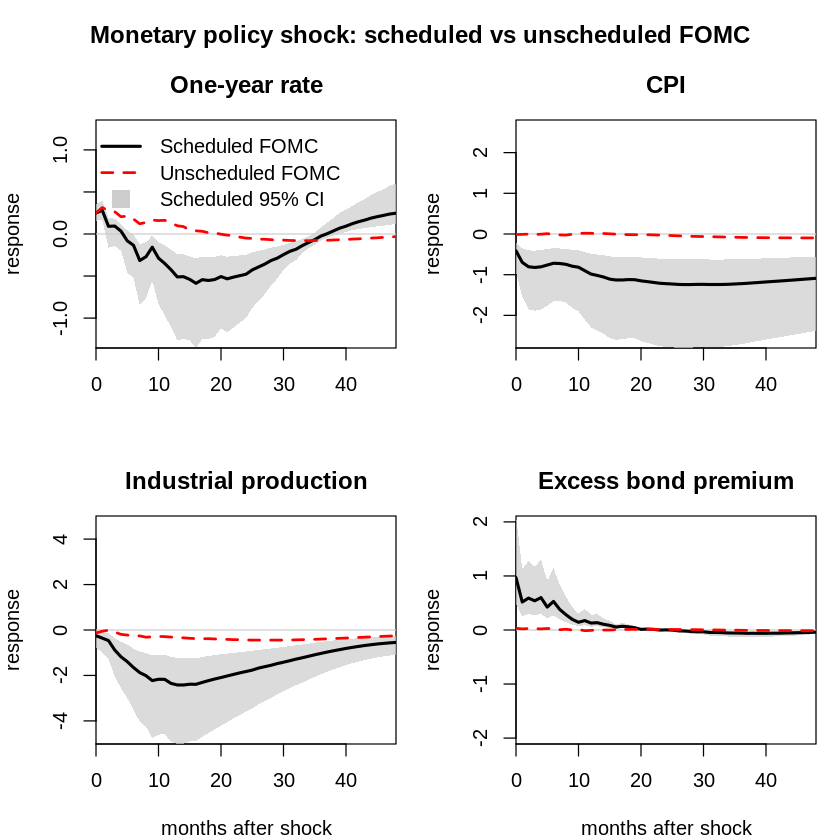

In [18]:
plot_sched_vs_unsched(proxy_irf_sched_95, proxy_irf_unsched_95)

In [19]:
plot_sched_vs_unsched <- function(irf_sched,
                                  irf_unsched,
                                  main_title = "Monetary policy shock: unscheduled vs scheduled FOMC") {

  # panel format
  df_unsched <- make_panel_df(irf_unsched, "Unscheduled FOMC")
  df_sched   <- make_panel_df(irf_sched,   "Scheduled FOMC")
  plot_df    <- rbind(df_unsched, df_sched)

  old_par <- par(no.readonly = TRUE)
  on.exit(par(old_par))

  par(mfrow = c(4, 2),
      mar  = c(3, 4, 2, 1),
      oma  = c(6, 0, 0, 0))

  var_levels <- levels(plot_df$var)

  # limits for unshed
  y_lims_unsched <- list(
    "One-year rate"       = c(-0.2, 0.4),
    "CPI"                 = c(-0.2, 0.2),
    "IP"                  = c(-0.6, 0.2),
    "Excess bond premium" = c(-0.1, 0.2)
  )

  H_plus1 <- nrow(irf_sched$irf)
  x_lims  <- c(0, H_plus1 - 1)
  x_ticks <- c(10, 20, 30, 40)
  x_ticks <- x_ticks[x_ticks <= x_lims[2]]

  for (v in var_levels) {

    # unscheduled
    d_left  <- subset(plot_df, var == v & method == "Unscheduled FOMC")
    ylim_L  <- y_lims_unsched[[v]]

    plot(d_left$period, d_left$irf,
         type = "n",
         xlim = x_lims,
         ylim = ylim_L,
         xlab = "",
         ylab = "Percent",
         main = paste(v, "(unscheduled)"),
         axes = FALSE)

    axis(1, at = x_ticks, labels = x_ticks)
    axis(2); box()
    abline(h = pretty(ylim_L), col = "grey85", lty = "dotted")
    abline(h = 0)

    lines(d_left$period, d_left$irf,   lwd = 2, col = "black")
    lines(d_left$period, d_left$lower, lty = 2, col = "black")
    lines(d_left$period, d_left$upper, lty = 2, col = "black")

    # scheduled
    d_right <- subset(plot_df, var == v & method == "Scheduled FOMC")

    yr <- range(c(d_right$lower, d_right$upper), na.rm = TRUE)
    pad <- 0.1 * diff(yr)
    if (!is.finite(pad) || pad == 0) pad <- 0.01
    ylim_R <- c(yr[1] - pad, yr[2] + pad)

    plot(d_right$period, d_right$irf,
         type = "n",
         xlim = x_lims,
         ylim = ylim_R,
         xlab = "",
         ylab = "Percent",
         main = paste(v, "(scheduled)"),
         axes = FALSE)

    axis(1, at = x_ticks, labels = x_ticks)
    axis(2); box()
    abline(h = pretty(ylim_R), col = "grey85", lty = "dotted")
    abline(h = 0)

    lines(d_right$period, d_right$irf,   lwd = 2, col = "red")
    lines(d_right$period, d_right$lower, lty = 2, col = "red")
    lines(d_right$period, d_right$upper, lty = 2, col = "red")
  }

  mtext("Months",   side = 1, outer = TRUE, line = 2)
  mtext(main_title, side = 1, outer = TRUE, line = 4, font = 2)
}

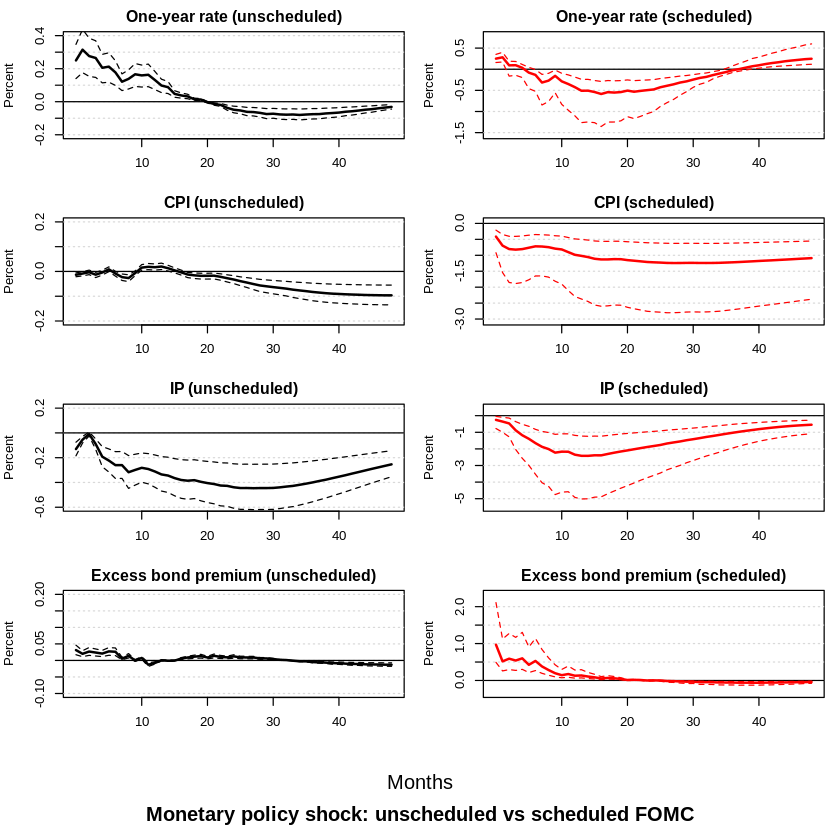

In [20]:
plot_sched_vs_unsched(proxy_irf_sched_95, proxy_irf_unsched_95)

###**Extension**

In [21]:
# FRED DATA (1950–2025)
getSymbols(c("INDPRO", "CORESTICKM159SFRBATL", "GS1", "AAA", "TB3MS", "GS10"),
           src = "FRED", from = "1950-01-01")

# Merge and convert to monthly frequency
all_data <- merge(INDPRO, CORESTICKM159SFRBATL, GS1, AAA, TB3MS, GS10)
all_data <- apply.monthly(all_data, last)
colnames(all_data) <- c("ip", "core_cpi", "gs1", "aaa", "tb3ms", "gs10")

df <- data.frame(
  date = index(all_data),
  coredata(all_data)
) %>%
  mutate(
    month = as.Date(paste(year(date), sprintf("%02d", month(date)), "01", sep = "-")),
    logip = log(ip),
    logcpi = log(core_cpi)
  )

# Proxy for EBP for the entire period
df <- df %>%
  mutate(
    ebp_proxy = case_when(
      year(date) <= 1961 ~ aaa - tb3ms,   # until 1962: Aaa – 3m T-bill
      TRUE              ~ aaa - gs10      # from 1962: Aaa – 10y Treasury
    )
  )

# Original EBP (1979–2012)
gk <- read_excel("gk2015.xlsx") %>%
  mutate(month = as.Date(paste(year, sprintf("%02d", month), "01", sep = "-"))) %>%
  select(month, ebp_original = ebp)

# Merge: proxy everywhere, original — where available
final_data <- df %>%
  left_join(gk, by = "month") %>%
  mutate(
    ebp = ifelse(!is.na(ebp_original), ebp_original, ebp_proxy)
  ) %>%
  select(month, logip, logcpi, gs1, ebp)

# Remove rows with missing values
final_data <- final_data %>%
  filter(!is.na(logip), !is.na(logcpi), !is.na(gs1), !is.na(ebp))

range(final_data$month)
print(summary(final_data$ebp))
head(final_data)

[1] "INDPRO"               "CORESTICKM159SFRBATL" "GS1"                 
[4] "AAA"                  "TB3MS"                "GS10"

[1] "1968-01-01" "2025-09-01"

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-1.32735 -0.08946  0.41209  0.48087  0.99000  2.97094 


,month,logip,logcpi,gs1,ebp
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,1968-01-01,3.592217,1.295237,5.43,0.64
2,1968-02-01,3.595793,1.301232,5.41,0.54
3,1968-03-01,3.598911,1.421218,5.58,0.37
4,1968-04-01,3.600357,1.424512,5.71,0.57
5,1968-05-01,3.611512,1.408116,6.14,0.40
6,1968-06-01,3.615179,1.514153,5.98,0.56


In [22]:
names(final_data)[names(final_data) == "month"] <- "date"

In [23]:
final_data <- final_data[final_data$date < as.Date("2025-01-01"), ]

In [24]:
head(final_data)

,date,logip,logcpi,gs1,ebp
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,1968-01-01,3.592217,1.295237,5.43,0.64
2,1968-02-01,3.595793,1.301232,5.41,0.54
3,1968-03-01,3.598911,1.421218,5.58,0.37
4,1968-04-01,3.600357,1.424512,5.71,0.57
5,1968-05-01,3.611512,1.408116,6.14,0.40
6,1968-06-01,3.615179,1.514153,5.98,0.56


In [25]:
instr_sp <- read_csv("sp500.csv")
instr_sp$date <- as.Date(instr_sp$date, format = "%Y-%m-%d")
instr_sp <- instr_sp[order(instr_sp$date), ]
instr_sp <- instr_sp[instr_sp$date >= as.Date("1968-01-01"), ]
instr_sp <- instr_sp[, c("date", "volume")]
summary(instr_sp)

Rows: 23748 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (6): open, high, low, close, adj close, volume
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


      date                volume         
 Min.   :1968-01-02   Min.   :6.650e+06  
 1st Qu.:1982-03-14   1st Qu.:5.564e+07  
 Median :1996-04-06   Median :3.987e+08  
 Mean   :1996-04-15   Mean   :1.541e+09  
 3rd Qu.:2010-05-24   3rd Qu.:3.253e+09  
 Max.   :2024-07-12   Max.   :1.146e+10  

In [26]:
fomc_impact <- read_csv("fomc_impact.csv")
fomc_impact$date <- as.Date(fomc_impact$date, format = "%Y-%m-%d")
fomc_impact <- fomc_impact[order(fomc_impact$date), ]
fomc_impact <- fomc_impact[fomc_impact$date >= as.Date("1968-01-01"), ]
summary(fomc_impact)

Rows: 844 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (2): diff, diff_norm
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


      date                 diff            diff_norm        
 Min.   :1968-01-09   Min.   :-336.566   Min.   :-0.124086  
 1st Qu.:1978-02-28   1st Qu.:  -2.556   1st Qu.:-0.010693  
 Median :1993-07-06   Median :   0.886   Median : 0.004334  
 Mean   :1994-05-07   Mean   :   1.905   Mean   : 0.002569  
 3rd Qu.:2009-08-11   3rd Qu.:   6.954   3rd Qu.: 0.015681  
 Max.   :2024-12-17   Max.   : 231.616   Max.   : 0.075653  
                      NA's   :4          NA's   :4          

In [27]:
create_volume_instrument_fixed <- function(df_daily, df_fomc,
                                          start_date = "1968-01-01",
                                          end_date = "2024-12-01") {

  # prepare data
  daily_dates <- as.Date(df_daily$date)
  fomc_dates <- as.Date(df_fomc$date)

  # cut
  start_date <- as.Date(start_date)
  end_date <- as.Date(end_date)

  fomc_dates <- fomc_dates[fomc_dates >= start_date & fomc_dates <= end_date]

  cat("=== VOLUME INSTRUMENT CREATION ===\n")
  cat("Period:", as.character(start_date), "to", as.character(end_date), "\n")
  cat("FOMC meetings in period:", length(fomc_dates), "\n")

  # check for dublicates
  exact_matches <- fomc_dates[fomc_dates %in% daily_dates]
  cat("Exact matches:", length(exact_matches), "\n")

  # schoks for same dates
  daily_xts <- xts(df_daily$volume, order.by = daily_dates)

  # Daily returns (log)
  volume_returns <- diff(log(daily_xts))

  # returns for exact matches
  fomc_shocks <- volume_returns[exact_matches]

  cat("\nFirst 5 FOMC shocks:\n")
  print(head(fomc_shocks, 5))

  # check for nules
  cat("\nShock statistics:\n")
  cat("Non-zero shocks:", sum(fomc_shocks != 0, na.rm = TRUE), "/", length(fomc_shocks), "\n")
  cat("NA shocks:", sum(is.na(fomc_shocks)), "\n")
  cat("Mean absolute shock:", mean(abs(fomc_shocks), na.rm = TRUE), "\n")

  # aggregate to monthly
  monthly_shocks <- numeric(0)
  monthly_dates <- character(0)

  # group by months
  for(year in year(start_date):year(end_date)) {
    for(month in 1:12) {
      # FOMC dates in the month
      month_fomc <- exact_matches[year(exact_matches) == year &
                                   month(exact_matches) == month]

      if(length(month_fomc) > 0) {
        # average shock
        shocks <- as.numeric(fomc_shocks[month_fomc])
        avg_shock <- mean(shocks, na.rm = TRUE)

        # if don't have than 0
        if(is.na(avg_shock)) avg_shock <- 0

        monthly_shocks <- c(monthly_shocks, avg_shock)
        monthly_dates <- c(monthly_dates, sprintf("%d-%02d", year, month))
      } else {
        # if no FOMC meetings than 0
        monthly_shocks <- c(monthly_shocks, 0)
        monthly_dates <- c(monthly_dates, sprintf("%d-%02d", year, month))
      }
    }
  }

  # build ts
  volume_ts <- ts(
    monthly_shocks,
    start = c(year(start_date), 1),
    frequency = 12
  )

  # names of months
  names(monthly_shocks) <- monthly_dates

  cat("\n=== FINAL INSTRUMENT ===\n")
  cat("Total months:", length(monthly_shocks), "\n")
  cat("Non-zero months:", sum(monthly_shocks != 0), "\n")
  cat("First 12 months:\n")
  print(head(monthly_shocks, 12))

  # visualisation
  plot(volume_ts, main = "Monthly Volume Shocks",
       ylab = "Log Return", xlab = "Year")
  abline(h = 0, col = "gray")

  return(list(
    monthly_ts = volume_ts,
    monthly_values = monthly_shocks,
    fomc_shocks = fomc_shocks,
    fomc_dates = exact_matches
  ))
}

=== VOLUME INSTRUMENT CREATION ===
Period: 1968-01-01 to 2024-12-01 
FOMC meetings in period: 520 
Exact matches: 515 

First 5 FOMC shocks:
                  [,1]
1968-01-09 -0.03860379
1968-02-06 -0.04789969
1968-03-05  0.07720583
1968-04-02 -0.19973111
1968-04-30  0.17843482

Shock statistics:
Non-zero shocks: 514 / 515 
NA shocks: 0 
Mean absolute shock: 0.1429379 

=== FINAL INSTRUMENT ===
Total months: 684 
Non-zero months: 499 
First 12 months:
     1968-01      1968-02      1968-03      1968-04      1968-05      1968-06 
-0.038603793 -0.047899692  0.077205826 -0.010648144  0.085109675  0.080960223 
     1968-07      1968-08      1968-09      1968-10      1968-11      1968-12 
-0.000747105  0.200234376 -0.039456233  0.084796729  0.121380575 -0.081611335 


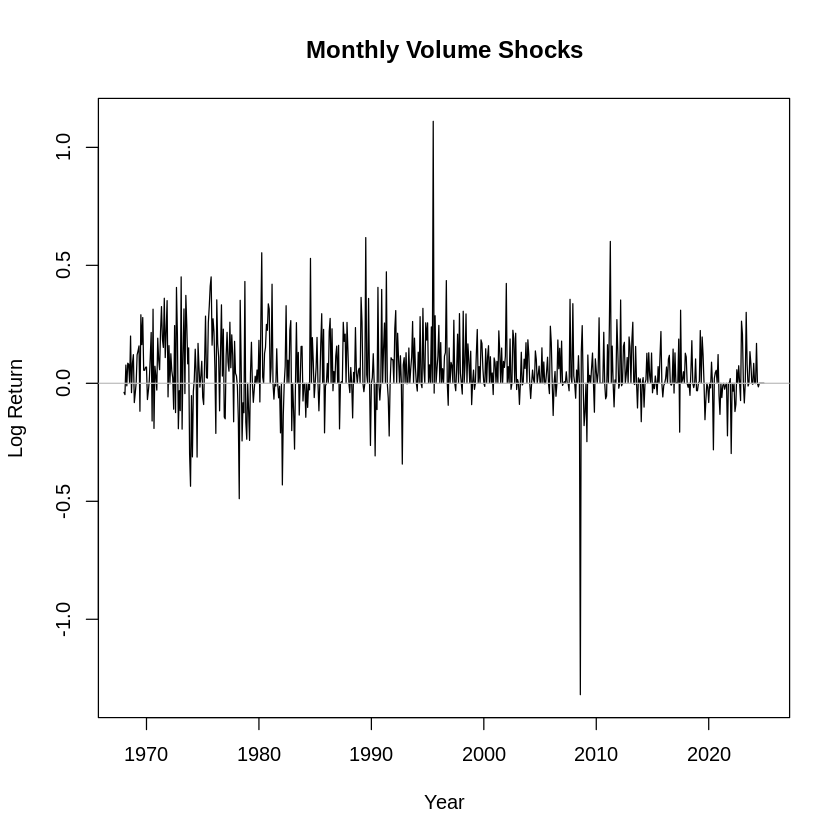

In [28]:
result <- create_volume_instrument_fixed(
  df_daily = instr_sp,
  df_fomc = fomc_impact,
  start_date = "1968-01-01",
  end_date = "2024-12-01"
)

In [29]:
ts_vector <- as.vector(t(result$monthly_ts))
instr <- ts(ts_vector, start = c(1968, 1), frequency = 12)

In [30]:
y_names <- c("logip", "logcpi", "gs1", "ebp")
y_ts  <- ts(final_data[, y_names], start = c(1968, 1), frequency = 12)

In [31]:
var_mod <- VAR(y_ts, p = p_lags, type = "const")

In [32]:
chol_irf  <- compute_chol_irf(var_mod)
proxy_irf <- compute_proxy_irf(var_mod, instr)

First-stage: F = 0.40; R2 = 0.06%


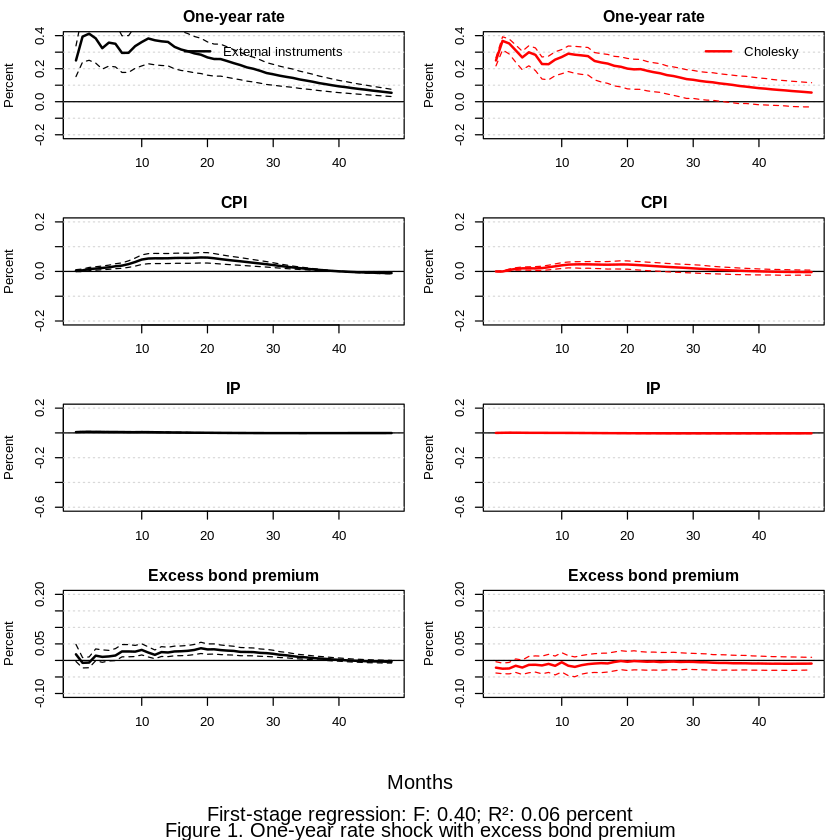

In [33]:
chol_df  <- make_panel_df(chol_irf,  "Cholesky")
proxy_df <- make_panel_df(proxy_irf, "External instruments")
plot_df  <- rbind(proxy_df, chol_df)

plot_gk_figure1(plot_df, proxy_irf)

In [34]:
fomc_mps <- read_excel("monetary-policy-surprises-data.xlsx",
                       sheet = "FOMC (update 2023)") %>%
  mutate(
    Date = as.Date(Date),
    year = year(Date),
    month = month(Date),
    ym = as.Date(paste(year, sprintf("%02d", month), "01", sep = "-"))
  )

In [35]:
mps_monthly <- fomc_mps %>%
  group_by(ym, Unscheduled) %>%
  summarise(mps_sum = sum(MPS, na.rm = TRUE), .groups = "drop") %>%
  pivot_wider(
    names_from = Unscheduled,
    values_from = mps_sum,
    names_prefix = "mps_",
    values_fill = 0
  ) %>%
  rename(
    mps_scheduled = mps_0,      # Unscheduled == 0 → scheduled
    mps_unscheduled = mps_1     # Unscheduled == 1 → unscheduled
  )

In [36]:
final_data <- final_data %>%
  left_join(mps_monthly, by = c("date" = "ym")) %>%
  mutate(
    mps_scheduled = replace_na(mps_scheduled, 0),
    mps_unscheduled = replace_na(mps_unscheduled, 0)
  )

In [37]:
instr_sched   <- ts(final_data$mps_scheduled,   start = c(1968, 1), frequency = 12)
instr_unsched <- ts(final_data$mps_unscheduled, start = c(1968, 1), frequency = 12)

In [38]:
proxy_irf_sched <- compute_proxy_irf(var_mod, instr_sched)

proxy_irf_unsched <- compute_proxy_irf(var_mod, instr_unsched)

chol_irf <- compute_chol_irf(var_mod)

First-stage: F = 0.98; R2 = 0.15%
First-stage: F = 16.89; R2 = 2.46%


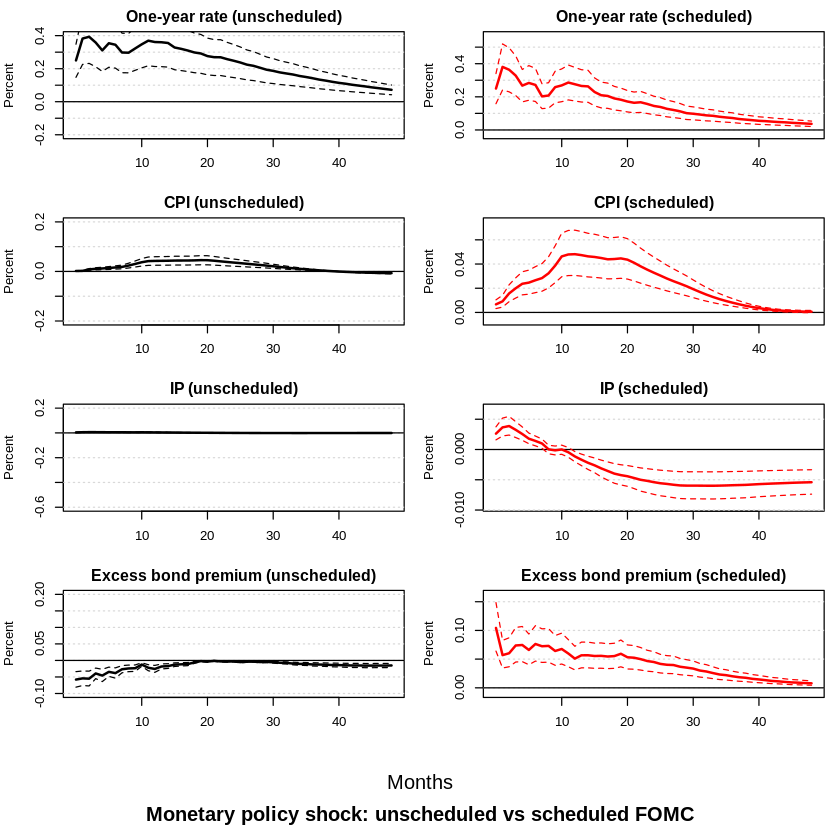

In [39]:
plot_sched_vs_unsched(proxy_irf_sched, proxy_irf_unsched)

In [59]:
library(tidyverse)
speeches <- read_csv("fed_speeches_1996_2020.csv", col_types = cols(date = col_character()))
speeches <- speeches %>% mutate(date = as.Date(date, "%Y%m%d"))

head(speeches)

link                                                               
1 https://www.federalreserve.gov/boarddocs/speeches/1996/19961219.htm
2 https://www.federalreserve.gov/boarddocs/speeches/1996/19961206.htm
3 https://www.federalreserve.gov/boarddocs/speeches/1996/19961205.htm
4 https://www.federalreserve.gov/boarddocs/speeches/1996/19961203.htm
5 https://www.federalreserve.gov/boarddocs/speeches/1996/19961125.htm
6 https://www.federalreserve.gov/boarddocs/speeches/1996/19961121.htm
  title                                                                                 
1 Supervision of bank risk-taking                                                       
2 Social security                                                                       
3 The challenge of central banking in a democratic society                              
4 Clearinghouses and risk management                                                    
5 Supervisory and regulatory responses to financial innovation and industry dynamics    
6 The transformation of the U.S. banking industry and resulting challenges to regulators
  speaker                       
1 Vice Chair Alice M. Rivlin    
2 Chairman Alan Greenspan       
3 Chairman Alan Greenspan       
4 Governor Edward W. Kelley, Jr.
5 Governor Susan M. Phillips    
6 Governor Laurence H. Meyer    
  event                                                                                                                           
1 At the The Brookings Institution National Issues Forum, Washington, D.C.                                                        
2 At the Abraham Lincoln Award Ceremony of the Union League of Philadelphia, Philadelphia, Pennsylvania                           
3 At the Annual Dinner and Francis Boyer Lecture of The American Enterprise Institute for Public Policy Research, Washington, D.C.
4 At the 1996 Payments System Risk Conference, Washington, D.C.                                                                   
5 At the BAI Seminar on Regulatory Policy Changes, Washington, D.C.                                                               
6 At the Ohio Bankers Day Convention, Columbus, Ohio                                                                              
  year
1 1996
2 1996
3 1996
4 1996
5 1996
6 1996
  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [67]:
summary(speeches)

    title                date             year_month       
 Length:1456        Min.   :1996-06-13   Length:1456       
 Class :character   1st Qu.:2002-10-22   Class :character  
 Mode  :character   Median :2007-03-06   Mode  :character  
                    Mean   :2007-12-26                     
                    3rd Qu.:2013-05-25                     
                    Max.   :2020-06-19                     
                    NA's   :1                              

In [61]:
speeches$date <- as.Date(speeches$date, format = "%Y-%m-%d")
speeches <- speeches[order(speeches$date), ]

In [62]:
speeches <- speeches[speeches$date >= as.Date("1968-01-01"), ]
speeches$year_month <- format(speeches$date, "%Y-%m")

In [ ]:
speeches

In [66]:
head(speeches)

title,date,year_month
<chr>,<date>,<chr>
Bank supervision in a world economy,1996-06-13,1996-06
Developments in electronic money and banking,1996-06-18,1996-06
Monetary policy objectives and strategy,1996-09-08,1996-09
Regulation and electronic payment systems,1996-09-19,1996-09
Small business is big business,1996-10-02,1996-10
"Bank supervision, regulation, and risk",1996-10-05,1996-10


=== VOLUME INSTRUMENT CREATION ===
Period: 1996-06-01 to 2020-06-01 
FOMC meetings in period: 1453 
Exact matches: 1382 

First 5 FOMC shocks:
                   [,1]
1996-06-13  0.001082020
1996-06-18  0.223887218
1996-09-19  0.004980015
1996-10-02  0.043131743
1996-10-07 -0.197612242

Shock statistics:
Non-zero shocks: 1379 / 1382 
NA shocks: 0 
Mean absolute shock: 0.1070986 

=== FINAL INSTRUMENT ===
Total months: 300 
Non-zero months: 274 
First 12 months:
     1996-01      1996-02      1996-03      1996-04      1996-05      1996-06 
 0.000000000  0.000000000  0.000000000  0.000000000  0.000000000  0.112484619 
     1996-07      1996-08      1996-09      1996-10      1996-11      1996-12 
 0.000000000  0.000000000  0.004980015 -0.029967507 -0.159452456  0.069967399 


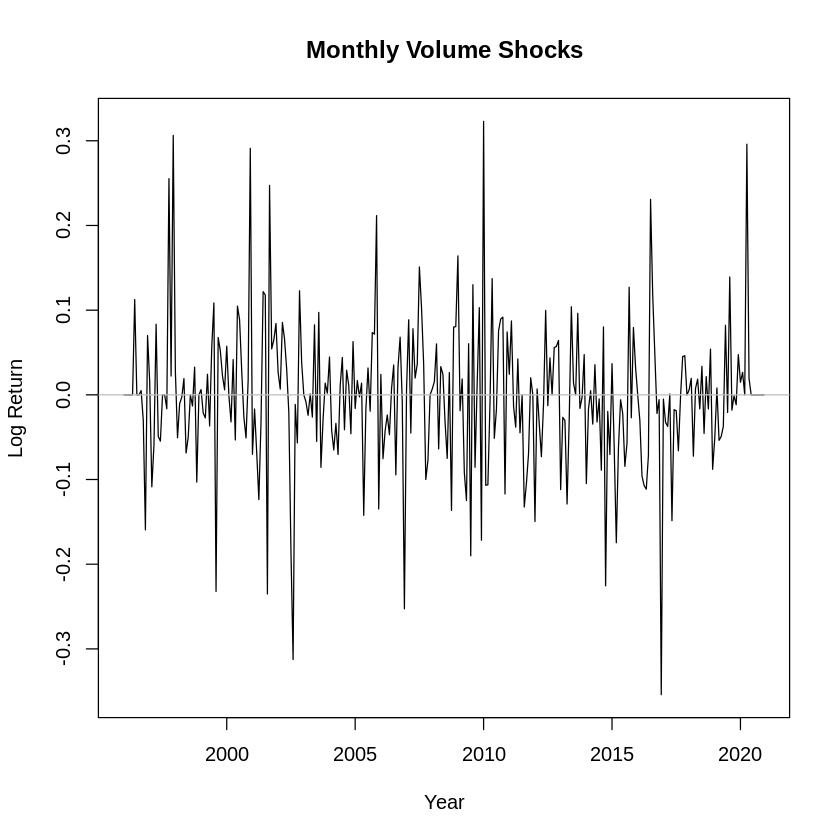

In [68]:
resultx <- create_volume_instrument_fixed(
  df_daily = instr_sp,
  df_fomc = speeches,
  start_date = "1996-06-01",
  end_date = "2020-06-01"
)

First-stage: F = 5.13; R2 = 1.76%


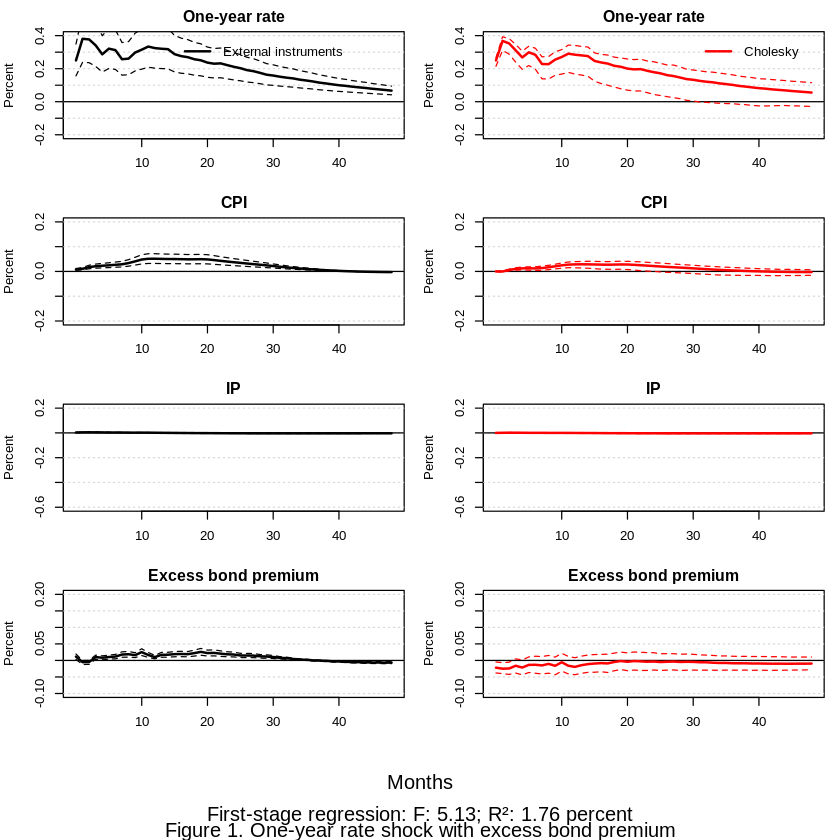

In [69]:
ts_vector <- as.vector(t(resultx$monthly_ts))
instr <- ts(ts_vector, start = c(1968, 1), frequency = 12)
y_names <- c("logip", "logcpi", "gs1", "ebp")
y_ts  <- ts(final_data[, y_names], start = c(1968, 1), frequency = 12)

var_mod <- VAR(y_ts, p = p_lags, type = "const")

chol_irf  <- compute_chol_irf(var_mod)
proxy_irf <- compute_proxy_irf(var_mod, instr)

chol_df  <- make_panel_df(chol_irf,  "Cholesky")
proxy_df <- make_panel_df(proxy_irf, "External instruments")
plot_df  <- rbind(proxy_df, chol_df)

plot_gk_figure1(plot_df, proxy_irf)

In [41]:
speeches_key <- speeches %>%
  mutate(
    # Chair: содержит "Chairman" или "Chair ", но НЕ "Vice Chair"
    is_chair = str_detect(speaker, regex("Chairman|\\bChair\\b", ignore_case = TRUE)) &
               !str_detect(speaker, regex("Vice", ignore_case = TRUE)),

    # Vice Chair: содержит "Vice Chair"
    is_vice_chair = str_detect(speaker, regex("Vice Chair", ignore_case = TRUE))
  ) %>%
  filter(is_chair | is_vice_chair) %>%
  mutate(date_clean = as.Date(date, format = "%Y%m%d")) %>%
  filter(!is.na(date_clean))

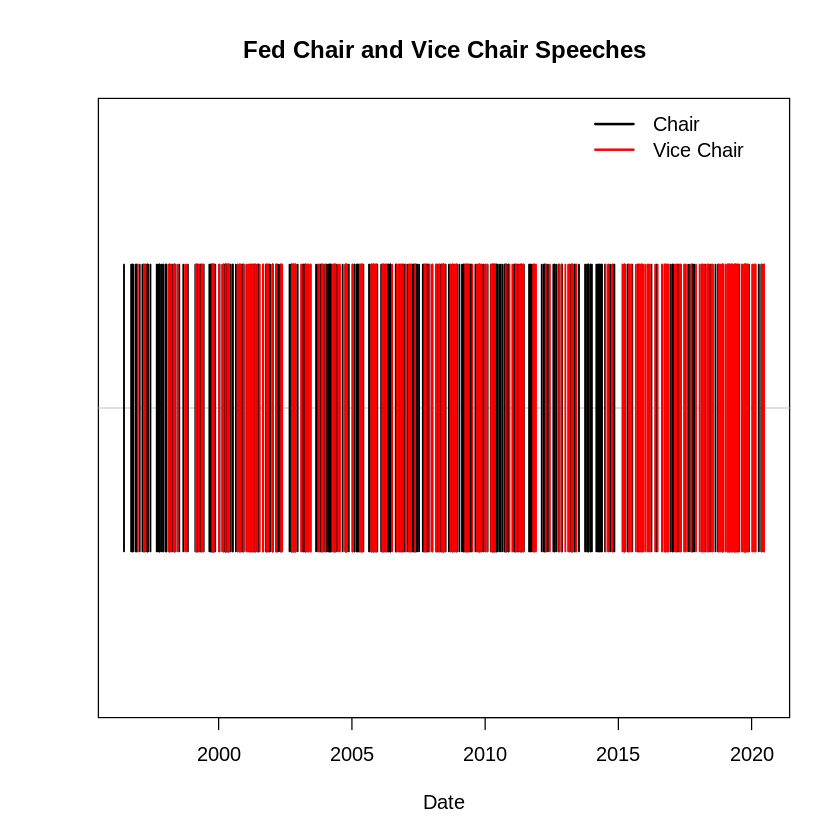

In [42]:
plot_data <- speeches_key %>%
  mutate(
    event_type = case_when(
      is_chair ~ "Chair",
      is_vice_chair ~ "Vice Chair"
    )
  )

plot(plot_data$date,
     rep(1, nrow(plot_data)),
     type = "n",
     xlab = "Date",
     ylab = "",
     yaxt = "n",
     main = "Fed Chair and Vice Chair Speeches")

abline(h = 1, col = "gray80")

# Chair — black
with(plot_data[plot_data$event_type == "Chair", ],
     segments(x0 = date, y0 = 0.8, x1 = date, y1 = 1.2,
              col = "black", lwd = 1.5))

# Vice Chair red
with(plot_data[plot_data$event_type == "Vice Chair", ],
     segments(x0 = date, y0 = 0.8, x1 = date, y1 = 1.2,
              col = "red", lwd = 1.5))

legend("topright",
       legend = c("Chair", "Vice Chair"),
       col = c("black", "red"),
       lwd = 2,
       bty = "n")

In [43]:
speeches_key %>%
  count(is_chair, is_vice_chair) %>%
  mutate(role = case_when(
    is_chair & !is_vice_chair ~ "Chair only",
    !is_chair & is_vice_chair ~ "Vice Chair only",
    is_chair & is_vice_chair ~ "Both (e.g., Yellen)"
  )) %>%
  select(role, n = n)

role,n
<chr>,<int>
Vice Chair only,291
Chair only,428


In [44]:
all_dates <- sort(unique(c(speeches_key$date, fomc_mps$Date)))

events_daily <- tibble(date = all_dates) %>%
  left_join(
    speeches_key %>%
      mutate(has_speech = TRUE) %>%
      select(date = date, has_speech, speaker),
    by = "date"
  ) %>%
  left_join(
    fomc_mps %>%
      select(date = Date, MPS, Unscheduled),
    by = "date"
  ) %>%
  mutate(
    has_speech = replace_na(has_speech, FALSE),
    MPS = replace_na(MPS, 0),
    event_type = case_when(
      has_speech & !is.na(Unscheduled) ~ "Speech + FOMC",
      has_speech ~ "Speech only",
      !is.na(Unscheduled) ~ ifelse(Unscheduled == 1, "Unscheduled FOMC", "Scheduled FOMC"),
      TRUE ~ "None"
    )
  )

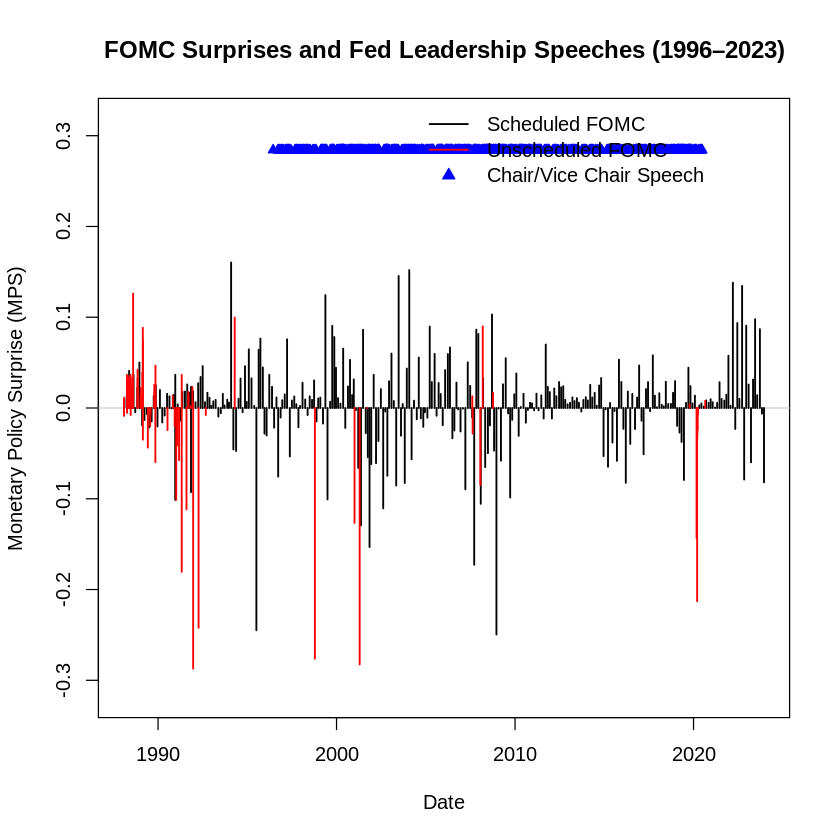

In [45]:
y_max <- max(abs(events_daily$MPS), na.rm = TRUE) * 1.1

plot(events_daily$date, events_daily$MPS,
     type = "n",
     xlab = "Date",
     ylab = "Monetary Policy Surprise (MPS)",
     main = "FOMC Surprises and Fed Leadership Speeches (1996–2023)",
     ylim = c(-y_max, y_max))

abline(h = 0, col = "gray80")

# FOMC: scheduled — black, unscheduled — red
with(events_daily[!is.na(events_daily$Unscheduled) & events_daily$Unscheduled == 0, ],
     segments(x0 = date, y0 = 0, x1 = date, y1 = MPS, col = "black", lwd = 1.5))

with(events_daily[!is.na(events_daily$Unscheduled) & events_daily$Unscheduled == 1, ],
     segments(x0 = date, y0 = 0, x1 = date, y1 = MPS, col = "red", lwd = 1.5))

# Речи — треугольники сверху
speech_days <- events_daily %>% filter(has_speech)
points(speech_days$date, rep(y_max * 0.9, nrow(speech_days)),
       pch = 24, bg = "blue", col = "blue", cex = 0.8)

legend("topright",
       legend = c("Scheduled FOMC", "Unscheduled FOMC", "Chair/Vice Chair Speech"),
       col = c("black", "red", "blue"),
       lty = c(1, 1, NA),
       pch = c(NA, NA, 24),
       pt.bg = c(NA, NA, "blue"),
       lwd = c(1.5, 1.5, NA),
       bty = "n")

###**Bonus**

In [53]:
fraser <- read_csv("fraser_speeches_3763.csv", show_col_types = FALSE) %>%
  transmute(
    source   = "FRASER",
    date     = as.Date(date),
    title    = str_squish(as.character(title)),
    speaker  = str_squish(as.character(speaker)),
    page_url = as.character(page_url),
    pdf_url  = as.character(pdf_url),
    text_url = as.character(text_url))

  frb <- read_csv("frb_speeches_index_1996.csv", show_col_types = FALSE) %>%
  transmute(
    source   = "FRB",
    date     = as.Date(date),
    title    = str_squish(as.character(title)),
    speaker  = str_squish(as.character(speaker)),
    page_url = as.character(speech_url),
    pdf_url  = NA_character_,
    text_url = NA_character_)

ERROR: Error: 'fraser_speeches_3763.csv' does not exist in current working directory ('/content').


In [ ]:
speeches_raw <- bind_rows(frb, fraser) %>%
  filter(!is.na(date)) %>%
  arrange(date, source)

cat("speeches_raw rows:", nrow(speeches_raw), "\n")
head(speeches_raw, 3)

In [ ]:
norm_title <- function(x) {
  x %>%
    tolower() %>%
    str_replace_all("&", " and ") %>%
    str_replace_all("[^a-z0-9 ]+", " ") %>%
    str_squish()}

speeches_norm <- speeches_raw %>%
  mutate(
    title_norm = norm_title(title),
    key_exact  = paste(date, title_norm)
  ) %>%
  arrange(date, source)
speeches_1 <- speeches_norm %>%
  group_by(key_exact) %>%
  arrange(factor(source, levels=c("FRB","FRASER"))) %>%
  slice(1) %>%
  ungroup()

# dubles
dedup_fuzzy_one_day <- function(df_day, thr = 0.12) {
  if (nrow(df_day) <= 1) return(df_day)
  keep <- rep(TRUE, nrow(df_day))
  for (i in 1:(nrow(df_day)-1)) {
    if (!keep[i]) next
    for (j in (i+1):nrow(df_day)) {
      if (!keep[j]) next
      d <- stringdist(df_day$title_norm[i], df_day$title_norm[j], method="jw")
      if (d <= thr) {
        # FRB is priopity
        if (df_day$source[i] == "FRB") keep[j] <- FALSE else keep[i] <- FALSE
      }
    }
  }
  df_day[keep, , drop=FALSE]}

speeches <- speeches_1 %>%
  group_by(date) %>%
  group_modify(~dedup_fuzzy_one_day(.x, thr = 0.12)) %>%
  ungroup() %>%
  arrange(date)

cat("raw:", nrow(speeches_raw), " -> dedup:", nrow(speeches), "\n")

In [ ]:
#stats
chair_vc <- tibble::tribble(
  ~start,       ~end,         ~chair,       ~vice_chair,
  "1996-01-01", "2006-01-31", "Greenspan",  "Blinder|Rivlin|Ferguson",
  "2006-02-01", "2014-01-31", "Bernanke",   "Kohn|Yellen",
  "2014-02-01", "2018-02-03", "Yellen",     "Fischer",
  "2018-02-04", "2022-01-31", "Powell",     "Clarida",
  "2022-02-01", "2100-01-01", "Powell",     "Brainard|Jefferson"
) %>% mutate(across(c(start,end), as.Date))

classify_role <- function(date, speaker) {
  if (is.na(date)) return("Other")
  s <- tolower(stringr::str_squish(ifelse(is.na(speaker), "", speaker)))

  r <- chair_vc %>% filter(date >= start & date <= end) %>% slice(1)
  if (nrow(r) == 0) return("Other")

  chair_pat <- tolower(r$chair[[1]])
  vc_pat    <- tolower(r$vice_chair[[1]])

  # convert NA to FALSE
  is_chair <- isTRUE(str_detect(s, chair_pat))
  is_vc    <- isTRUE(str_detect(s, vc_pat))

  if (is_chair) return("Chair")
  if (is_vc)    return("Vice Chair")
  "Other"}

speeches <- speeches %>%
  mutate(
    speaker = ifelse(is.na(speaker), "", speaker),
    role = vapply(seq_len(n()), function(i) classify_role(date[i], speaker[i]), character(1)))

table(speeches$role, useNA = "ifany")

In [ ]:
speeches %>%
  summarise(
    n_total = n(),
    n_unique_speakers = n_distinct(speaker[speaker!=""]),
    date_min = min(date, na.rm=TRUE),
    date_max = max(date, na.rm=TRUE)
  )

top_speakers <- speeches %>%
  filter(speaker!="") %>%
  count(speaker, sort=TRUE) %>%
  slice_head(n=20)

top_speakers

In [ ]:
speeches <- speeches %>%
  mutate(year = year(date),
         ym   = floor_date(date, "month"))

# speeches per year
ggplot(speeches, aes(x=year)) +
  geom_bar() +
  labs(title="Speeches per year (FRB + FRASER, deduped)", x="Year", y="Count")

# speeches per month by role
ggplot(speeches %>% filter(!is.na(ym)), aes(x=ym, fill=role)) +
  geom_bar() +
  labs(title="Speeches over time by role", x="Month", y="Count") +
  theme(axis.text.x = element_text(angle=45, hjust=1))

In [ ]:
# IRFs speeches
getSymbols("DGS1", src="FRED")  # daily 1Y treasury constant maturity
dgs1 <- na.omit(DGS1)

# daily change in percentage points
dgs1_chg <- diff(dgs1)

speech_days <- speeches %>%
  filter(!is.na(date)) %>%
  distinct(date, role)

# pull surprise for each speech day
speech_iv_daily <- data.frame(
  date = as.Date(index(dgs1_chg)),
  dgs1_chg = as.numeric(dgs1_chg)
) %>%
  inner_join(speech_days, by="date") %>%
  mutate(ym = as.yearmon(date))

# aggregate monthly
iv_speech_all_m <- speech_iv_daily %>%
  group_by(ym) %>%
  summarise(iv = sum(dgs1_chg, na.rm=TRUE), .groups="drop")

iv_speech_chair_m <- speech_iv_daily %>%
  filter(role=="Chair") %>%
  group_by(ym) %>%
  summarise(iv = sum(dgs1_chg, na.rm=TRUE), .groups="drop")

iv_speech_vc_m <- speech_iv_daily %>%
  filter(role=="Vice Chair") %>%
  group_by(ym) %>%
  summarise(iv = sum(dgs1_chg, na.rm=TRUE), .groups="drop")

In [ ]:
# Var
start_year  <- start(Y_ts)[1]
start_month <- start(Y_ts)[2]
nT <- nrow(Y_ts)

ym_grid <- seq(as.yearmon(sprintf("%d-%02d", start_year, start_month)),
               by = 1/12, length.out = nT)

mk_ts_iv <- function(iv_monthly_df) {
  tmp <- data.frame(ym = ym_grid) %>%
    left_join(iv_monthly_df, by="ym") %>%
    mutate(iv = ifelse(is.na(iv), 0, iv))
  ts(tmp$iv, start=c(start_year, start_month), frequency=12)}

iv_speech_all_ts   <- mk_ts_iv(iv_speech_all_m)
iv_speech_chair_ts <- mk_ts_iv(iv_speech_chair_m)
iv_speech_vc_ts    <- mk_ts_iv(iv_speech_vc_m)

In [ ]:
plot_compare_three <- function(irf_a, irf_b, irf_c,
                               lab_a="All speeches", lab_b="Chair", lab_c="Vice Chair",
                               var_names=c("gs1","logcpi","logip","ebp"),
                               var_titles=c("One-year rate","CPI","IP","Excess bond premium"),
                               cols=c("black","blue","red"),
                               lwd=2) {

  make_df <- function(irf_obj, label){
    H <- nrow(irf_obj$irf)
    data.frame(
      h = 0:(H-1),
      response = rep(var_names, each=H),
      irf  = as.vector(irf_obj$irf),
      lo   = as.vector(irf_obj$lower),
      hi   = as.vector(irf_obj$upper),
      type = label
    )
  }

  labs <- c(lab_a, lab_b, lab_c)
  dfp <- rbind(make_df(irf_a, lab_a), make_df(irf_b, lab_b), make_df(irf_c, lab_c))

  oldpar <- par(no.readonly = TRUE)
  on.exit(par(oldpar), add = TRUE)

  par(mfrow=c(2,2), mar=c(3,3,2,1))

  for (j in seq_along(var_names)) {
    v <- var_names[j]
    d <- dfp[dfp$response == v, ]
    ylim <- range(d$lo, d$hi, na.rm=TRUE)

    plot(NA, xlim=c(0, max(d$h)), ylim=ylim,
         xlab="Months", ylab="IRF", main=var_titles[j])
    abline(h=0, lty=3)

    # lines
    for (k in seq_along(labs)) {
      dd <- d[d$type == labs[k], ]
      lines(dd$h, dd$irf, col=cols[k], lwd=lwd)
    }

    # legend
    if (j == 1) {
      legend("bottom", legend=labs, col=cols, lwd=lwd, bty="n", cex=0.9)
    }
  }
}

plot_compare_three(proxy_irf_speech_all_95,
                   proxy_irf_speech_chair_95,
                   proxy_irf_speech_vc_95)

In [ ]:
# meetings and all speeches
iv_pooled_ts <- iv_all_ts + iv_speech_all_ts
proxy_irf_pooled_95 <- compute_proxy_irf(var_mod, iv_pooled_ts, ci_level=0.95)

# pooled vs meetings only
plot_compare_three(proxy_irf_all_95, proxy_irf_pooled_95, proxy_irf_speech_all_95,
                   lab_a="FOMC only", lab_b="FOMC+Speeches", lab_c="Speeches only")

In [ ]:
# regimes/breaks
iv_for_breaks  <- iv_pooled_ts
iv_for_regimes <- iv_pooled_ts
# monthly date for Y_ts (freq=12)
ts_month_dates <- function(x_ts) {
  stopifnot(is.ts(x_ts), frequency(x_ts) == 12)
  as.Date(as.yearmon(time(x_ts)))}

In [ ]:
# align residual and instrument z for a given VAR model and IV ts
align_u_z <- function(var_model, iv_ts, policy_name = "gs1") {
  U <- residuals(var_model)
  var_names <- colnames(var_model$y)
  colnames(U) <- var_names

  if (!(policy_name %in% var_names)) {
    stop(sprintf("policy_name='%s' not found in VAR variables: %s",
                 policy_name, paste(var_names, collapse = ", ")))
  }

  p <- var_model$p
  y_dates <- ts_month_dates(var_model$y)

  # residuals correspond to t = (p+1 ... T)
  u_pol  <- as.numeric(U[, policy_name])
  u_date <- y_dates[(p + 1):length(y_dates)]

  # instrument aligned similarly (drop first p)
  z_full <- as.numeric(iv_ts)
  z_use  <- z_full[(p + 1):(p + length(u_pol))]

  keep <- is.finite(u_pol) & is.finite(z_use)
  tibble(
    date     = u_date[keep],
    u_policy = u_pol[keep],
    z        = z_use[keep]
  )
}

In [ ]:
# date to c(year, month)
to_ym <- function(d) c(as.integer(format(d, "%Y")), as.integer(format(d, "%m")))

In [ ]:
# regime labeling
assign_regime <- function(d) {
  cut(
    d,
    breaks = as.Date(c(
      "1968-01-01",
      "1979-10-01",
      "1987-09-01",
      "2007-08-01",
      "2015-12-01",
      "2020-03-01",
      "2026-01-01"
    )),
    right  = FALSE,
    labels = c(
      "Pre-Volcker",
      "Volcker",
      "Great Moderation",
      "GFC/ZLB/QE",
      "Normalization",
      "COVID"
    )
  )
}

In [ ]:
# VAR fitting inside short regimes
fit_var_safe <- function(y_ts_sub, p_target = 12, type = "const") {
  nT <- nrow(as.matrix(y_ts_sub))
  # keeping p such that nT is not too small vs parameters
  p_use <- min(p_target, max(1, floor((nT - 1) / 10)))
  if (p_use < p_target) message("Regime sample short: using p = ", p_use, " instead of ", p_target)
  vars::VAR(y_ts_sub, p = p_use, type = type)}

In [ ]:
# convert proxy irf object to long df
irf_to_df <- function(proxy_irf_obj, label, var_names) {
  H <- nrow(proxy_irf_obj$irf)
  expand.grid(h = 0:(H-1), var = var_names) |>
    as_tibble() |>
    mutate(
      irf    = as.vector(proxy_irf_obj$irf[, var_names]),
      lower  = as.vector(proxy_irf_obj$lower[, var_names]),
      upper  = as.vector(proxy_irf_obj$upper[, var_names]),
      regime = label
    )
}

In [ ]:
# First-stage stability and breaks
uz <- align_u_z(var_mod, iv_for_breaks, policy_name = "gs1")

# df for strucchange
uz_df <- as.data.frame(uz)

fs_form <- u_policy ~ z
environment(fs_form) <- environment()

# SupF/Fstats
fstats_obj <- strucchange::Fstats(fs_form, data = uz_df, from = 0.15, to = 0.85)
supF_test  <- strucchange::sctest(fstats_obj)

cat("First-stage stability test (SupF)")
print(supF_test)

# Bai–Perron breakpoints and BIC choice
bp_all <- strucchange::breakpoints(fs_form, data = uz_df, h = 0.15)
bic_vals <- BIC(bp_all)
m_opt <- which.min(bic_vals) - 1  # m starts at 0

bp_opt <- strucchange::breakpoints(bp_all, breaks = m_opt)
bp_idx <- bp_opt$breakpoints

bp_dates <- if (length(bp_idx) && all(!is.na(bp_idx))) uz_df$date[bp_idx] else as.Date(character(0))

cat("Breakpoints\n")
cat("Optimal breaks by BIC:", m_opt, "\n")
cat("Estimated break dates:")
print(bp_dates)

# plot Fstats
Fvec <- as.numeric(fstats_obj$Fstats)
nF   <- length(Fvec)
n    <- nrow(uz_df)

from <- 0.15
to   <- 0.85

start_i <- max(1, ceiling(from * n))
end_i   <- min(n, floor(to * n))

idx <- round(seq(start_i, end_i, length.out = nF))
idx <- pmin(pmax(idx, 1), n)

plot_df <- tibble(
  date  = uz_df$date[idx],
  Fstat = Fvec)

p <- ggplot(plot_df, aes(x = date, y = Fstat)) +
  geom_line() +
  labs(
    title = "First-stage stability",
    subtitle = paste0("SupF p-value = ", signif(supF_test$p.value, 3),"; BIC-optimal breaks = ", m_opt),x = NULL, y = "F-statistic")
if (length(bp_dates) > 0) p <- p + geom_vline(xintercept = bp_dates, linetype = 2)
print(p)

In [ ]:
# IRFs by regimes

uz_reg <- align_u_z(var_mod, iv_for_regimes, policy_name = "gs1") %>%
  mutate(regime = assign_regime(date))

# CI table
regime_table <- uz_reg %>%
  filter(!is.na(regime)) %>%
  group_by(regime) %>%
  summarise(
    start = min(date),
    end   = max(date),
    n_obs = n(),
    .groups = "drop"
  )

cat("Regime table")
print(regime_table)

# IRFs for regimes
irf_regime_list <- list()

for (i in seq_len(nrow(regime_table))) {
  rname <- as.character(regime_table$regime[i])
  d0 <- regime_table$start[i]
  d1 <- regime_table$end[i]

  y_sub  <- window(Y_ts, start = to_ym(d0), end = to_ym(d1))
  iv_sub <- window(iv_for_regimes, start = to_ym(d0), end = to_ym(d1))

  if (nrow(as.matrix(y_sub)) < 80) {
    message("Skipping regime '", rname, "' (too few observations).")
    next}

  vm_sub <- fit_var_safe(y_sub, p_target = p_lags, type = "const")
# proxy-irf
irf_sub <- compute_proxy_irf(vm_sub, iv_sub, ci_level = 0.95)
irf_regime_list[[rname]] <- irf_sub
}

# plot
var_names <- colnames(var_mod$y)
vars_to_plot <- intersect(c("gs1","logcpi","logip","ebp"), var_names)

var_title <- function(v) {
    if (v == "gs1") "One-year rate"
    else if (v == "logcpi") "CPI"
    else if (v == "logip") "IP"
    else if (v == "ebp") "Excess bond premium"
    else v}

regimes <- intersect(c("Volcker", "Great Moderation"),names(irf_regime_list))

base_cols <- c("black", "blue", "red", "darkgreen", "purple", "orange")
cols <- setNames(rep(base_cols, length.out = length(regimes)), regimes)
oldpar <- par(no.readonly = TRUE)
on.exit(par(oldpar), add = TRUE)
par(mfrow = c(2, 2), mar = c(4, 4, 3, 2))

H <- nrow(irf_regime_list[[1]]$irf)
hgrid <- 0:(H-1)

for (v in vars_to_plot) {
  # matrice for v
  ymat <- sapply(regimes, function(rg) irf_regime_list[[rg]]$irf[, v])
  ylim <- range(ymat, na.rm = TRUE)

  plot(hgrid, ymat[, 1], type = "n",
        main = var_title(v),
        xlab = "", ylab = "",
        ylim = ylim, axes = FALSE)

  axis(1); axis(2, las = 1); box()
  abline(h = 0, lty = 3)

  for (rg in regimes) {
    lines(hgrid, irf_regime_list[[rg]]$irf[, v], col = cols[rg], lwd = 2)
    if (v == vars_to_plot[1]) {
      legend("topright", legend = regimes, col = cols[regimes],
             lty = 1, lwd = 2, bty = "n")
    }
  }
}